The goal is to explore the network sturctural differences when changing the train test split algorithm.

In [1]:
from data_loader import DataLoader, NodeType
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import copy
from pprint import pprint

import sys
sys.path.append("../models")
sys.path.append("../evaluation")

from evaluation import Evaluator
from common_neighbors_model import CommonNeighborsModel
from popularity_model import GamePopularityModel

In [2]:
def examine_networks(networks, data_loaders, network_names):
    output = {}
    assert len(networks) == len(network_names)
    def get_user_degrees(network):
        user_nodes = [node for node, data in network.nodes(data=True) if data['node_type'] == NodeType.USER]
        degrees = {node: val for (node, val) in network.degree()}
        return [degrees[user_node] for user_node in user_nodes]
    
    def get_game_degrees(network):
        game_nodes = [node for node, data in network.nodes(data=True) if data['node_type'] == NodeType.GAME]
        degrees = {node: val for (node, val) in network.degree()}
        return [degrees[game_node] for game_node in game_nodes]
    
    def get_user_closeness_centrality(network):
        user_nodes = [node for node, data in network.nodes(data=True) if data['node_type'] == NodeType.USER]
        centrality = nx.closeness_centrality(network)
        return [centrality[user_node] for user_node in user_nodes]
    
    def get_game_closeness_centrality(network):
        game_nodes = [node for node, data in network.nodes(data=True) if data['node_type'] == NodeType.GAME]
        centrality = nx.closeness_centrality(network)
        return [centrality[game_node] for game_node in game_nodes]
    
    def plot_histogram(values, log, bins, axis, title):
        axis.hist(values, bins=bins, color='skyblue', edgecolor='black')
        axis.set_title(title)
        axis.set_xlabel('Values')
        axis.set_ylabel('Frequency')
        if log:
            axis.set_yscale('log')
        
    def histogram_maker(function, title):
        fig, axes = plt.subplots(len(networks), figsize=(10, 8))
        fig.suptitle(title)
        fig.subplots_adjust(hspace=2)
        values_per_network = [function(network) for network in networks]
        min_val = min([v for values in values_per_network for v in values])
        max_val = max([v for values in values_per_network for v in values])
        bins = np.linspace(min_val, max_val, num=100)
        for ii, (values, network_name) in enumerate(zip(values_per_network, network_names)):
            plot_histogram(values, True, bins, axes[ii], f'{network_name}')
    
    print('Making degree histograms.')
    histogram_maker(get_user_degrees, 'User Degrees')
    histogram_maker(get_game_degrees, 'Game Degrees')

    # print('Making centrality histograms.')
    # histogram_maker(get_user_closeness_centrality, 'User Closeness Centrality')
    # histogram_maker(get_game_closeness_centrality, 'Game Closeness Centrality')

    def average_maker(function, title):
        values_per_network = [function(network) for network in networks]
        for values, network_name in zip(values_per_network, network_names):
            average = sum(values) / len(values)
            output[f'average_{title}_{network_name}'] = average

    print('Making average user degrees.')
    average_maker(get_user_degrees, 'user_degrees')
    average_maker(get_game_degrees, 'game_degrees')
    
    def model_impact_maker(model):
        evaluator = Evaluator(top_N_games_to_eval = 500)
        for data_loader, split_name in zip(data_loaders, network_names[1:]):
            model.set_data_loader(data_loader)
            model.train()
            evaluator.reset(model)
            evaluator.plot_top_N_hit_percentage_percentiles(10)
            evaluator.plot_log_user_percentile_positional_error()
            evaluator.compute_mean_positional_error()
            evaluator.compute_top_N_hit_percentage(10)
            evaluator.plot_roc_curve()
            evaluator.compute_auc_roc()
            evaluator.plot_user_based_roc_curve()
            evaluator.compute_user_based_auc_roc()
            evaluator.save_metrics(f'train_test_split_experiment_model_metrics_{split_name}_{model.name()}', overwrite=True)

    print('Making model impact.')
    model_impact_maker(CommonNeighborsModel())
    model_impact_maker(GamePopularityModel())

    return output

Making degree histograms.
Making average user degrees.
Making model impact.
{'average_game_degrees_full_network': 8.952889752306945,
 'average_game_degrees_random_network': 7.16228404912232,
 'average_game_degrees_stratified_user_degree_network': 7.16228404912232,
 'average_game_degrees_stratified_user_network': 7.16228404912232,
 'average_user_degrees_full_network': 25.8076,
 'average_user_degrees_random_network': 20.646,
 'average_user_degrees_stratified_user_degree_network': 20.646,
 'average_user_degrees_stratified_user_network': 20.646}


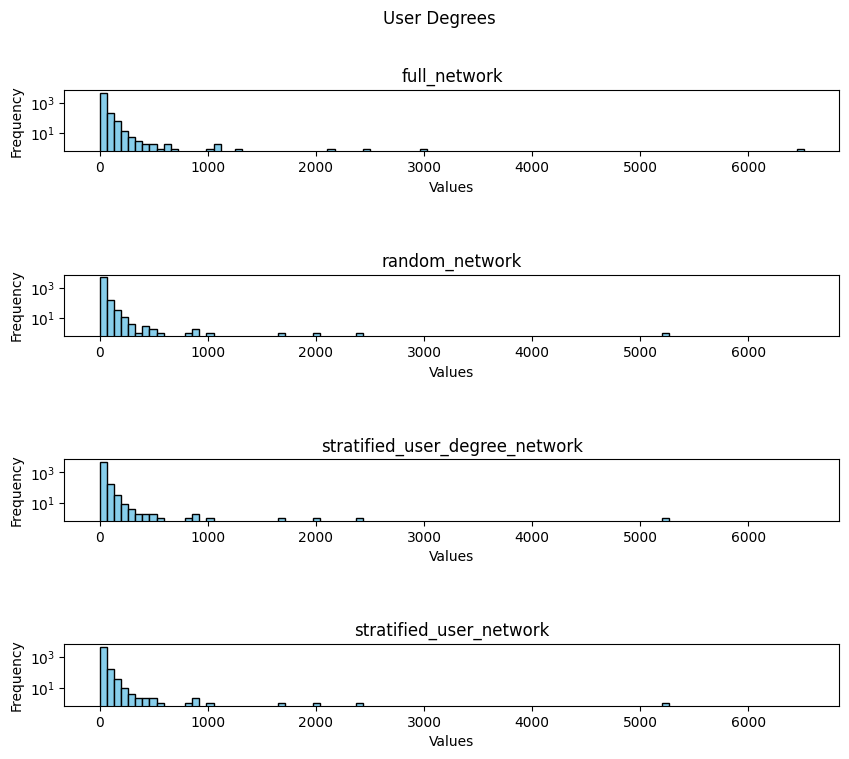

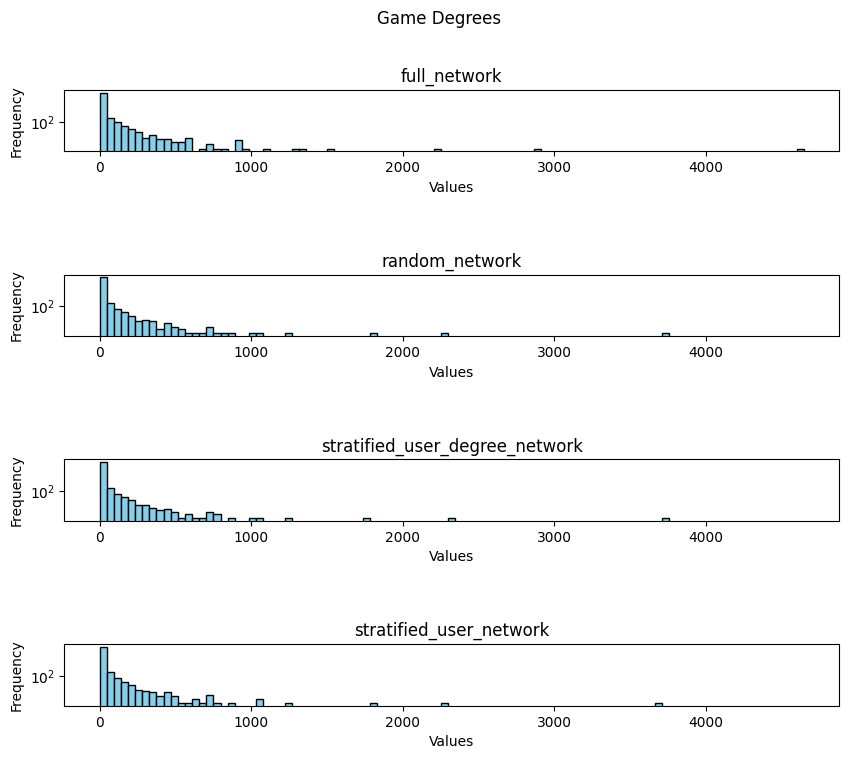

In [3]:
random_data_loader = DataLoader()
full_network = random_data_loader.get_full_network()

random_seed = 1

random_data_loader.load_random_train_test_network(full_network, seed=random_seed, train_percentage=0.8, test_percentage=0.2)
random_train_network = copy.deepcopy(random_data_loader.train_network)

stratified_user_degree_data_loader = DataLoader()
stratified_user_degree_data_loader.load_stratified_user_degree_train_test_network(full_network, seed=random_seed, train_percentage=0.8, test_percentage=0.2)
stratified_user_degree_train_network = copy.deepcopy(stratified_user_degree_data_loader.train_network)

stratified_user_data_loader = DataLoader()
stratified_user_data_loader.load_stratified_user_train_test_network(full_network, seed=random_seed, train_percentage=0.8, test_percentage=0.2)
stratified_user_train_network = copy.deepcopy(stratified_user_data_loader.train_network)

output = examine_networks([full_network, random_train_network, stratified_user_degree_train_network, stratified_user_train_network], [random_data_loader, stratified_user_degree_data_loader, stratified_user_data_loader], ['full_network', 'random_network', 'stratified_user_degree_network', 'stratified_user_network'])
pprint(output)

In [4]:
print(len([node for node, degree in full_network.degree() if degree == 1]))
print(len(list(nx.isolates(random_train_network))))
print(len(list(nx.isolates(stratified_user_degree_train_network))))
print(len(list(nx.isolates(stratified_user_train_network))))

7085
1581
1535
1544
